# Case Study: Particle Drag

---

This is a simple case study drawing on the modeling work reported in [Tavanashad et al. (2021)](https://www.sciencedirect.com/science/article/abs/pii/S0301932220306443?via%3Dihub).

## Basic Dimensional Analysis

First we demonstrate some basic tasks in dimensional analysis; the `pybuck` package automates many basic computations.


In [1]:
import grama as gr

from pybuck import *
from plotnine import *

DF = gr.Intention()

Input variables and their physical dimensions.

| Input | Symbol | Dimensions |
|--|--|--|
| Fluid density | $\rho_f$ | $\frac{M}{L^3}$ |
| Particle density | $\rho_p$ | $\frac{M}{L^3}$ |
| Slip velocity | $W_{\text{avg}}$ | $\frac{L}{T}$ |
| Particle diameter | $d_p$ | $L$ |
| Fluid dynamic viscosity | $\mu_f$ | $\frac{M}{LT}$ |
| Particle volume fraction | $\phi$ | $-$ |

We construct the *dimension matrix* with compact syntax. Zeros are automatically filled in.


In [2]:
df_dim = col_matrix(
    rho_f = dict(M=1, L=-3),
    rho_p = dict(M=1, L=-3),
    W_avg = dict(L=1, T=-1),
    d_p   = dict(L=1),
    mu_f  = dict(M=1, L=-1, T=-1),
    phi   = dict(L=0),
)
df_dim


,rowname,rho_f,rho_p,W_avg,d_p,mu_f,phi
0,T,0,0,-1,0,-1,0
1,L,-3,-3,1,1,-1,0
2,M,1,1,0,0,1,0


State a standard dimensionless basis.


In [3]:
df_standard = col_matrix(
    Re_m = dict(rho_f=1, phi=1, W_avg=1, d_p=1, mu_f=-1), # Reynolds number
    f    = dict(rho_p=1, rho_f=-1),                       # Density ratio
    phi  = dict(phi=1),
)
df_standard


,rowname,Re_m,f,phi
0,phi,1,0,1
1,d_p,1,0,0
2,rho_f,1,-1,0
3,mu_f,-1,0,0
4,rho_p,0,1,0
5,W_avg,1,0,0


Sanity-check that this standard basis is dimensionless:


In [4]:
inner(df_dim, df_standard)


,rowname,Re_m,f,phi
0,T,0,0,0
1,L,0,0,0
2,M,0,0,0


## Empirical Dimension Reduction

Next we demonstrate combining *empirical dimension reduction* with dimensional analysis. This allows one to equip data-driven methods with physical interpretation.

Generate some data from Equation (2) in Tavanashad et al. (2021).


In [5]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from model_drag import *

## Simulate collecting data
np.random.seed(101)
n_data = 500

Q_all = np.random.random((n_data, len(Q_lo))) * (Q_hi - Q_lo) + Q_lo
F_all = np.zeros(n_data)
for i in range(n_data):
    res = fcn_drag(Q_all[i])
    F_all[i] = res

df_data = pd.DataFrame(
    data=Q_all,
    index=range(n_data),
    columns=Q_names
)
df_data["f"] = F_all

## Log-transform the input variables
df_log = df_data.copy()
df_log[Q_names] = np.log(df_log[Q_names])
df_log

,rho_f,rho_p,W_avg,d_p,mu_f,phi,f
0,6.911030,10.952052,0.228145,-4.018459,-6.569837,-1.049339,3.416399e+04
1,6.868384,11.400455,2.014089,-3.921874,-6.765360,-1.581630,1.313076e+06
2,6.842020,11.271647,2.271027,-3.729576,-8.259584,-1.269171,7.200406e+07
3,6.952536,10.226698,1.969593,-2.951354,-8.557387,-1.956440,5.025048e+08
4,6.843103,11.507228,1.738005,-2.842150,-6.504856,-1.337167,3.746183e+06
...,...,...,...,...,...,...,...
495,6.828421,10.592086,1.950475,-2.665938,-7.242273,-2.008782,3.901125e+07
496,6.956275,11.507513,0.209772,-2.406827,-6.233445,-1.979437,2.377249e+05
497,6.950403,11.124297,1.995743,-3.253635,-6.667766,-1.321868,6.293176e+06
498,6.873033,11.003948,2.259113,-2.694133,-6.357306,-1.173624,1.579046e+07


### Approach 1: Reduction via least squares regression

Use a simplified approach to estimate the active subspace: ordinary least squares regression.


In [6]:
## Fit an OLS to the log-transformed data
lm_1 = smf.ols(
    "f ~ rho_f + rho_p + W_avg + d_p + mu_f + phi",
    data=df_log
).fit()
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      f   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     30.29
Date:                Sat, 25 Sep 2021   Prob (F-statistic):           5.73e-31
Time:                        08:46:00   Log-Likelihood:                -10484.
No. Observations:                 500   AIC:                         2.098e+04
Df Residuals:                     493   BIC:                         2.101e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.861e+08   1.73e+09      0.568      0.570   -2.42e+09    4.39e+09
rho_f      -3.072e+08   2.47e+08     -1.243      0.214   -7.93e+08    1.78e+08
rho_p       -2.69e+07    1.3e+07     -2.069      0.039   -5.25e+07   -1.35e+06
W_avg       7.715e+07   2.42e+07      3.189      0.002    2.96e+07    1.25e+08
d_p         6.128e+07   1.54e+07      3.989      0.000    3.11e+07    9.15e+07
mu_f       -2.303e+08   2.01e+07    -11.449      0.000    -2.7e+08   -1.91e+08
phi         2.956e+07   3.73e+07      0.792      0.429   -4.38e+07    1.03e+08
==============================================================================
Omnibus:                      665.288   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            86218.390
Skew:                           6.723   Prob(JB):                         0.00
Kurtosis:                      65.910   Cond. No.                     1.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared value is low, around $R^2 = 0.26$. This may indicate that the dimension reduction is poor and inaccurate.

The following code extracts the active direction weights from the statsmodels regression object.


In [7]:
df_dr_1 = pd.DataFrame({
    "rowname": lm_1.params.index[1:],
    "pi": lm_1.params.values[1:]
})
df_dr_1 = normalize(df_dr_1)
df_dr_1


,rowname,pi
0,rho_f,-0.771109
1,rho_p,-0.067519
2,W_avg,0.193621
3,d_p,0.153804
4,mu_f,-0.578086
5,phi,0.074188


Generate a diagnostic shadow plot; this is a visual complement to inspecting the $R^2$ value.


/home/zach/Git/py_grama/grama/tran_summaries.py:327: UserWarning: ignoring df_weights columns {'rowname'}


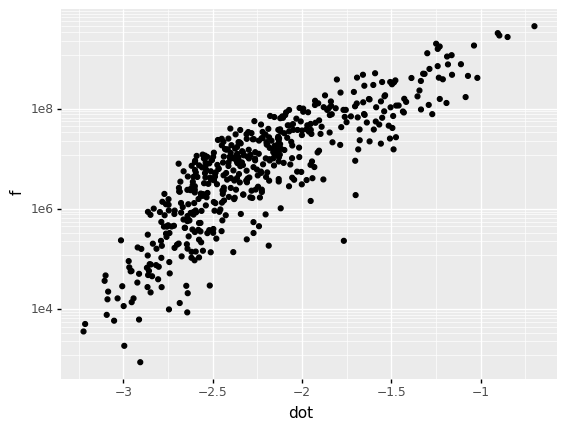

<ggplot: (8788349481286)>

In [8]:
(
    df_log
    >> gr.tf_inner(df_weights=transpose(df_dr_1))
    >> ggplot(aes("dot", "f"))
    + geom_point()
    + scale_y_log10()
)

Note that the scatter in the shadow plot is considerable, reflecting the poor $R^2$ value. Note however that the scatter is visually even on this vertical log-scale; this indicates [heteroskedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity) in the response that is stabilized by a log-transform. We'll return to this observation in Approach 2.


Check the physical dimensions of the active direction.


In [9]:
inner(df_dim, df_dr_1)

,rowname,pi
0,T,0.384465
1,L,3.441396
2,M,-1.416714


We don't need a bootstrap to tell that the active direction is not a dimensionless number! It passes the [interocular trauma test](https://stats.stackexchange.com/questions/458069/source-for-inter-ocular-trauma-test-for-significance); clearly something has gone wrong in this approach to dimension reduction, and we need a different approach.


### Approach 2: Log-transform the response before fitting

There are a few tacks we could take from this point: We could try to use a [polynomial ridge approximation](https://psdr.readthedocs.io/en/latest/surrogate.html) to identify a higher-dimensional active subspace, which may give a better fit. But let's tug on that heteroskedastic observation above: If log-transforming the response stabilizes the variance of the output, perhaps we can get a more stable fit if we log-transform the response.


In [10]:
## Log-transform the output variables
df_loglog = df_log.copy()
df_loglog["f"] = np.log(df_log["f"])
df_loglog


,rho_f,rho_p,W_avg,d_p,mu_f,phi,f
0,6.911030,10.952052,0.228145,-4.018459,-6.569837,-1.049339,10.438927
1,6.868384,11.400455,2.014089,-3.921874,-6.765360,-1.581630,14.087883
2,6.842020,11.271647,2.271027,-3.729576,-8.259584,-1.269171,18.092233
3,6.952536,10.226698,1.969593,-2.951354,-8.557387,-1.956440,20.035116
4,6.843103,11.507228,1.738005,-2.842150,-6.504856,-1.337167,15.136248
...,...,...,...,...,...,...,...
495,6.828421,10.592086,1.950475,-2.665938,-7.242273,-2.008782,17.479361
496,6.956275,11.507513,0.209772,-2.406827,-6.233445,-1.979437,12.378869
497,6.950403,11.124297,1.995743,-3.253635,-6.667766,-1.321868,15.654976
498,6.873033,11.003948,2.259113,-2.694133,-6.357306,-1.173624,16.574916


Re-fit the linear regression on the loglog transformed data:


In [11]:
## Approach 2: Fit an OLS to the loglog-transformed data
lm_2 = smf.ols(
    "f ~ rho_f + rho_p + W_avg + d_p + mu_f + phi",
    data=df_loglog
).fit()
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      f   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.687e+04
Date:                Sat, 25 Sep 2021   Prob (F-statistic):               0.00
Time:                        08:46:00   Log-Likelihood:                 316.82
No. Observations:                 500   AIC:                            -619.6
Df Residuals:                     493   BIC:                            -590.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.2003      0.720    -12.775      0.000     -10.615      -7.785
rho_f          2.4557      0.103     23.934      0.000       2.254       2.657
rho_p         -0.2252      0.005    -41.701      0.000      -0.236      -0.215
W_avg          2.0025      0.010    199.387      0.000       1.983       2.022
d_p            1.9908      0.006    312.159      0.000       1.978       2.003
mu_f          -1.9957      0.008   -238.951      0.000      -2.012      -1.979
phi            0.4052      0.016     26.143      0.000       0.375       0.436
==============================================================================
Omnibus:                      167.885   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              837.947
Skew:                          -1.394   Prob(JB):                    1.10e-182
Kurtosis:                       8.697   Cond. No.                     1.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The $R^2 = 0.998$, which is essentially perfect! Much more promising... let's extract the leading direction and construct a shadow plot.


In [12]:
df_dr_2 = pd.DataFrame({
    "rowname": lm_2.params.index[1:],
    "pi": lm_2.params.values[1:]
})
df_dr_2 = normalize(df_dr_2)
df_dr_2


,rowname,pi
0,rho_f,0.575611
1,rho_p,-0.052774
2,W_avg,0.469369
3,d_p,0.466629
4,mu_f,-0.467776
5,phi,0.094986


To make comparison against the previous shadow plot, let's construct both shadow plots using the original log-transformed data (do the projection with the non-log-transformed response).


/home/zach/Git/py_grama/grama/tran_summaries.py:327: UserWarning: ignoring df_weights columns {'rowname'}
/home/zach/Git/py_grama/grama/tran_summaries.py:327: UserWarning: ignoring df_weights columns {'rowname'}


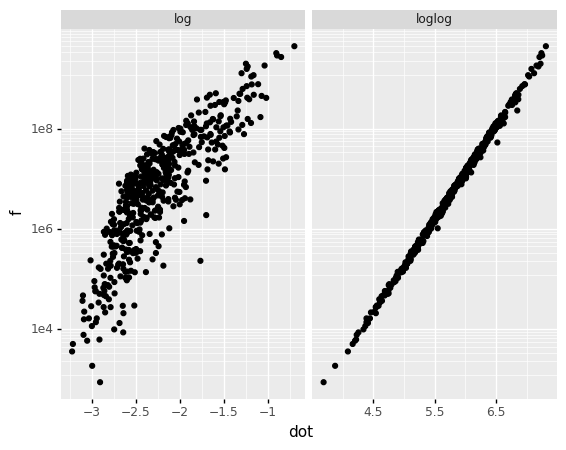

<ggplot: (8788349485306)>

In [13]:
(
    df_log
    >> gr.tf_inner(df_weights=transpose(df_dr_2))
    >> gr.tf_mutate(method="loglog")
    >> gr.tf_bind_rows(
        df_log
        >> gr.tf_inner(df_weights=transpose(df_dr_1))
        >> gr.tf_mutate(method="log")
    )
    
    >> ggplot(aes("dot", "f"))
    + geom_point()
    + scale_y_log10()
    + facet_grid("~method", scales="free_x")
)

Clearly, the `loglog` approach 2 is giving us a considerably better fit, suggesting that a single active variable is sufficient to describe the response. However, is that resulting quantity dimensionless? Let's check:

In [14]:
inner(df_dim, df_dr_2)

,rowname,pi
0,T,-0.001593
1,L,-0.164739
2,M,0.055061


We should run a bootstrap test, but at first-glance it seems this active direction is nearly dimensionless. Let's re-express the leading direction in terms of the standard dimensionless basis:


In [15]:
express(df_dr_2, df_standard)

,rowname,pi
0,Re_m,0.475769
1,f,-0.076308
2,phi,-0.380783


This suggests the drag model we're studying *might* be reduced to a function of one dimensionless number, approximately

$$\pi = \text{Re}_m^{0.48} (\rho_p/\rho_f)^{-0.08} \phi^{-0.38}$$

We can validate this proposed number by using it to manually reduce the data. First, compute the manually-defined weights:


In [19]:
df_manual = (
    df_standard
    >> gr.tf_mutate(pi=0.48 * DF.Re_m - 0.08 * DF.f - 0.38 * DF.phi)
    >> gr.tf_select("rowname", "pi")
)
df_manual

,rowname,pi
0,phi,0.10
1,d_p,0.48
2,rho_f,0.56
3,mu_f,-0.48
4,rho_p,-0.08
5,W_avg,0.48


Now construct a shadow plot; use the empirical DR as a side-by-side comparison:


/home/zach/Git/py_grama/grama/tran_summaries.py:327: UserWarning: ignoring df_weights columns {'rowname'}
/home/zach/Git/py_grama/grama/tran_summaries.py:327: UserWarning: ignoring df_weights columns {'rowname'}


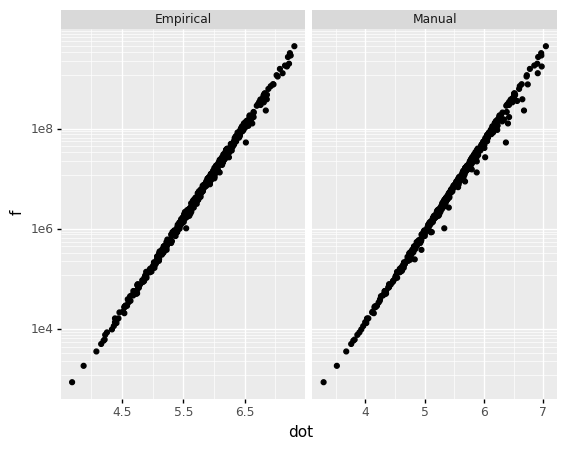

<ggplot: (8788346163270)>

In [20]:
(
    df_log
    >> gr.tf_inner(df_weights=transpose(df_dr_2))
    >> gr.tf_mutate(method="Empirical")
    >> gr.tf_bind_rows(
        df_log
        >> gr.tf_inner(df_weights=transpose(df_manual))
        >> gr.tf_mutate(method="Manual")
    )
    
    >> ggplot(aes("dot", "f"))
    + geom_point()
    + scale_y_log10()
    + facet_grid("~method", scales="free_x")
)

These look essentially the same.
